# Using exisiting models for out-of-sample data

By resampling the data, existing models can be used in preparations or recording conditions they were not trained on, without the need to train a new model. Here, we try to apply the model trained on cerebellar GC mEPSCs on mEPSPs (current-clamp data). In this scenario, there are several differences to the trainig data: mEPSPs are upward and the kinetics are slower. In addition, the recording mode is different, which may impact the noise characteristics of the data. 

If the performance is satisfactory, we can use the model with some small parameter adjustments, if not we can opt to train a new model using transfer learning.

In [1]:
import sys
sys.path.append('../../core/')
from miniML import MiniTrace, EventDetection
from miniML_plot_functions import miniML_plots

## Running miniML

Generating the trace object works the same as in the miniML tutorial.

In [2]:
filename = '../../example_data/gc_mEPSP_mini_trace.h5'
scaling = 1e3
unit = 'mV'

# get from h5 file
trace = MiniTrace.from_h5_file(filename=filename,
                               tracename='mini_data',
                               scaling=scaling,
                               unit=unit)

Let's plot and inspect the loaded data:

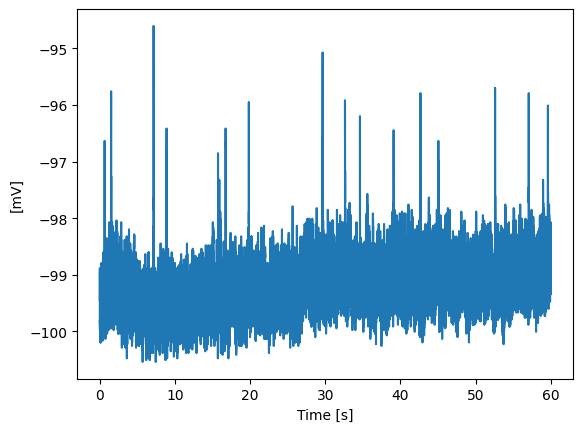

In [3]:
trace.plot_trace()

Creating and initializing a miniML *EventDetection* object also works very similar. Two things should be considered when using a model for an out-of-sample preparation:
- direction parameters:
  "event_direction" specifies the direction of the events in the data. In this case, we have to change it to "positive", because mEPSPs are positive.
  
  "training_direction" specifies the direction of the events during model training. Here we use the GC mEPSC model, so the training_direction has to be set to "negative".
  
- Window size (here: variable *win_size*) has to be specified:
  This parameter, together with "resample_to_600" (see one cell later), effectively control the resampling. resample_to_600 can be either **True** (default) or **False**. If True, the data will be resampled to match a win_size of 600 for inference, based on the indicated window size. E.g. for win_size = 6000, the data would be downsampled by a factor of 10. This is necessary, because after training, the input size for a given model is fixed. This also goes for models that were trained using transfer learning: because the first layers are frozen, the input size remains unchanged during TL, and will be identical to the input size of the base model. So, instead of actually adjusting the input size, we resample the data for inference, to achieve the same effect.


The GC mEPSC model was trained with a window size of 600 points. This was big enough to fully capture one mEPSC, but is too small for mEPSPs, which have slower kinetics. But before we adjust win_size, let's use the model with the standard value of 600 points (no resampling) and only the adjusted event_direction, to see how it performs:

Model loaded from ../../models/GC_lstm_model.h5
293/293 - 7s - 7s/epoch - 24ms/step

Event statistics:
-------------------------
    Number of events: 27
    Average score: 0.787
    Event frequency: 0.4500 Hz
    Mean amplitude: 0.5512 mV
    Median amplitude: 0.4114 mV
    Std amplitude: 0.5326 mV
    CV amplitude: 0.966
    Mean charge: 0.00232 pC
    CV charge: 2.288
    Mean 10-90 risetime: 0.630 ms
    Mean half decay time: 1.744 ms
    Tau decay: 2.267 ms
-------------------------


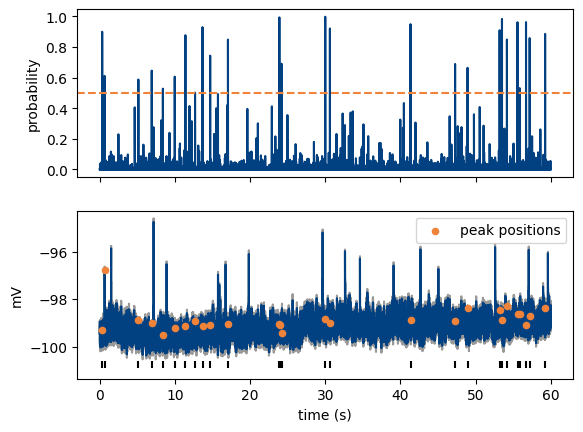

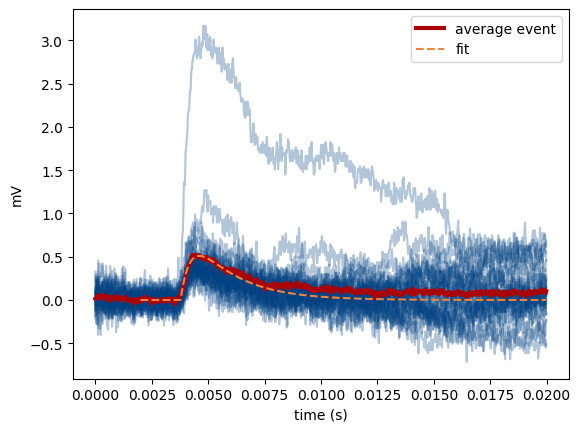

In [4]:
model = '../../models/GC_lstm_model.h5'
win_size = 600 # Stays the same for now
threshold = 0.5
event_direction = 'positive'
training_direction = 'negative'

detection = EventDetection(data=trace,
                           model_path=model,
                           window_size=win_size,
                           model_threshold=threshold,
                           batch_size=512,
                           event_direction=event_direction,
                           training_direction=training_direction,
                           compile_model=True,
                           verbose=2)

detection.detect_events(eval=True,
                        convolve_win=30,
                        resample_to_600=True)

MiniPlots = miniML_plots(data=detection)
MiniPlots.plot_prediction(include_data=True, plot_filtered_prediction=False, plot_filtered_trace=True, plot_event_params=False)
MiniPlots.plot_event_overlay()

Clearly, the detection performance is not great and most of the larger mEPSPs are missed. Most detected events have very fast kinetics, faster than expected for mEPSPs. To potentially improve the performance in out-of-sample data, we can now adjust *win_size*. In this instance, the events are slower, so we need to choose a larger *win_size*, for example 3600, and make sure that resample_to_600 is set to **True**. Now the data will get downsampled by a factor of 6 for inference.

In [5]:
model = '../../models/GC_lstm_model.h5'
win_size = 3600 # Adjusted to resample data for inference.
threshold = 0.5
event_direction = 'positive'
training_direction = 'negative'

detection = EventDetection(data=trace,
                           model_path=model,
                           window_size=win_size,
                           model_threshold=threshold,
                           batch_size=512,
                           event_direction=event_direction,
                           training_direction=training_direction,
                           compile_model=True,
                           verbose=2)

detection.detect_events(eval=True,
                        convolve_win=30,
                        resample_to_600=True)

Model loaded from ../../models/GC_lstm_model.h5
49/49 - 2s - 2s/epoch - 32ms/step

Event statistics:
-------------------------
    Number of events: 30
    Average score: 0.955
    Event frequency: 0.5000 Hz
    Mean amplitude: 2.0417 mV
    Median amplitude: 1.9972 mV
    Std amplitude: 1.1688 mV
    CV amplitude: 0.572
    Mean charge: 0.02245 pC
    CV charge: 0.713
    Mean 10-90 risetime: 1.721 ms
    Mean half decay time: 5.683 ms
    Tau decay: 9.026 ms
-------------------------


## Inspect the results

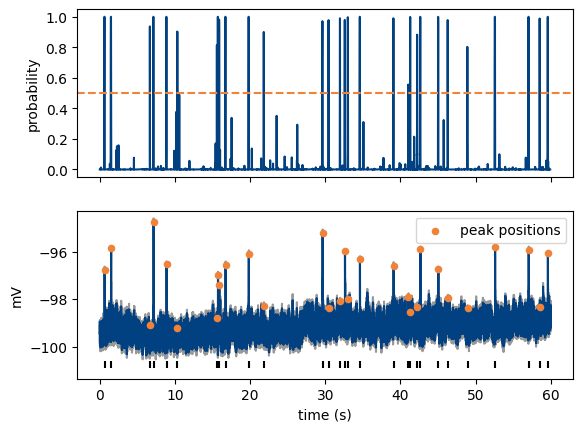

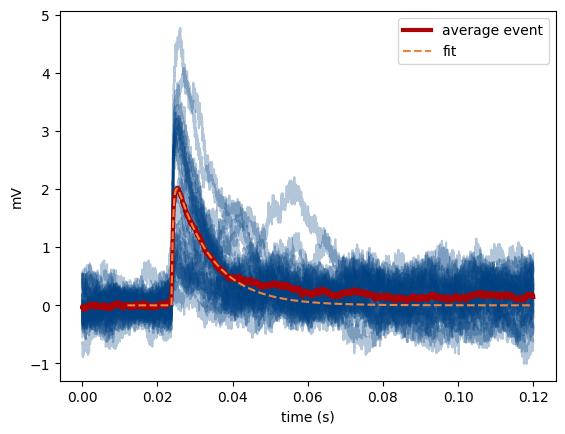

In [6]:
%matplotlib inline
MiniPlots = miniML_plots(data=detection)

MiniPlots.plot_prediction(include_data=True, plot_filtered_prediction=False, plot_filtered_trace=True, plot_event_params=False)
MiniPlots.plot_event_overlay()

Now detection performance is much better, albeit not perfect. We could detect 30 mEPSPs in this trace (compared to 27 without resampling), and the shape of the detected events is much better (note the slower decay time of the detected events). The event scores (i.e., peak values of the model output) are also much better. 

In this case, we decided to train a new model for GC mEPSPs (see tutorial_TL.ipynb and miniML_documentation.pdf), but in many cases, resampling the data, by adjusting the *win_size* parameter can work well enough, especially under otherwise consistent recording conditions (e.g. same rig with constant noise levels etc.).